# Task 1: Symbolic Unconditioned Generation

# Section 1: Exploratory Analysis

## Context 
- This dataset comes from the NES-MDB Dataset, which is 5278 soundtracks of 397 NES games. It was built from the assembly code of NES games and shared in a github repository (https://github.com/chrisdonahue/nesmdb?tab=readme-ov-file#midi-format).
- We chose this dataset because the 8-bit music offers a very manageable vocabulary for potentially easier model training. Even with 'low' vocabulary, we think it can still produce musically engaging results and allow us to experiment with more sophisticated generative architectures such as Transformers.
## Discussion
- Data preprocessing: The data was already cleaned very well for our purposes. However we filtered out pieces that were less than 20 seconds. This is because the dataset also contained sound effects that we are not planning to generate. Furthermore, we decided to not use files with unreasonably high ticks in the midi (over a million)
- Training data: The data comes with training, validation and test sets. We trained on the entire dataset (after filtering) so that we can maximize the vocabulary and learning of our models.
## Code (Tables and Graphs): 

In [107]:
import os
import glob
import pandas as pd
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
data_path = r"data/nesmdb_midi/" 

folders_to_process = {
    "train": os.path.join(data_path, "train"),
    "test": os.path.join(data_path, "test"),
    "valid": os.path.join(data_path, "valid")
}

folders_to_process

{'train': 'data/nesmdb_midi/train',
 'test': 'data/nesmdb_midi/test',
 'valid': 'data/nesmdb_midi/valid'}

In [3]:
midi_paths = (
    glob.glob(os.path.join(folders_to_process['train'], "*.mid")) + 
    glob.glob(os.path.join(folders_to_process['test'], "*.mid")) + 
    glob.glob(os.path.join(folders_to_process['valid'], "*.mid"))
)
print(f"Found {len(midi_paths)} MIDI files.")

Found 5278 MIDI files.


# Basic Statistics of our midi files

In [12]:
records = []
num_skipped = 0
for path in tqdm(midi_paths):
    try:
        pm = pretty_midi.PrettyMIDI(path)
        duration = pm.get_end_time()
        if duration < 30:
            num_skipped += 1
            continue

        all_notes = [note for inst in pm.instruments for note in inst.notes]
        total_notes = len(all_notes)
        if total_notes > 0:
            velocities = np.array([note.velocity for note in all_notes])
            unique_pitches = len({note.pitch for note in all_notes})
            avg_velocity = velocities.mean()
            note_density = total_notes / duration
        else:
            unique_pitches = 0
            avg_velocity = np.nan
            note_density = 0

        records.append({
            'path': path,
            'file': os.path.basename(path),
            'duration_s': duration,
            'total_notes': total_notes,
            'unique_pitches': unique_pitches,
            'avg_velocity': avg_velocity,
            'num_instruments': len(pm.instruments),
            'note_density': note_density
        })
    except ValueError as e:
        num_skipped += 1
        # print(f"Skipping file {os.path.basename(path)} due to error: {e}")
    except Exception as e:
        num_skipped += 1
        # print(f"Skipping file {os.path.basename(path)} due to an unexpected error: {e}")
print(f'Skipped {num_skipped} number of files.')


  0%|          | 0/5278 [00:00<?, ?it/s]

Skipped 3265 number of files.


In [13]:
df = pd.DataFrame(records)
cleaned_paths = df['path'].tolist()
print(cleaned_paths)
df.head()
df.describe()

['data/nesmdb_midi/train/387_Wizardry_ProvingGroundsofTheMadOverlord_16_17Werdna.mid', 'data/nesmdb_midi/train/195_KonamiWaiWaiWorld_18_19FinalStageBossBGM.mid', 'data/nesmdb_midi/train/050_ChaosWorld_20_21Chaos.mid', 'data/nesmdb_midi/train/100_Falsion_05_06FlyingHighStage5BGM.mid', 'data/nesmdb_midi/train/336_TenchioKurauII_ShokatsuKoumeiDen_18_19Cave2.mid', 'data/nesmdb_midi/train/076_DonkeyKongCountry4_00_01Theme.mid', 'data/nesmdb_midi/train/217_MajouDensetsuII_DaimashikyouGalious_11_12Ending.mid', 'data/nesmdb_midi/train/227_MegaMan4_06_07BrightManStage.mid', 'data/nesmdb_midi/train/314_SummerCarnival_92_Recca_10_11BostuneFinalBoss.mid', 'data/nesmdb_midi/train/291_ShadowoftheNinja_02_03Stage1.mid', 'data/nesmdb_midi/train/220_MarbleMadness_00_01Level1.mid', 'data/nesmdb_midi/train/086_DragonFighter_07_08InitiveofaGhostStage5.mid', 'data/nesmdb_midi/train/365_UchuuKeibitaiSDF_06_07Stage5.mid', 'data/nesmdb_midi/train/122_FireEmblem_AnkokuRyutoHikarinoTsurugi_08_09Shop1WeaponryClo

,duration_s,total_notes,unique_pitches,avg_velocity,num_instruments,note_density
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,57.250304,1189.710383,40.232489,5.909758,3.635867,21.218514
std,29.878490,1084.553276,12.940051,2.373904,0.594077,14.958237
min,30.006848,17.000000,2.000000,1.000000,1.000000,0.480332
25%,38.338231,519.000000,31.000000,4.232335,3.000000,10.514910
50%,47.923605,874.000000,39.000000,5.662162,4.000000,16.855626
75%,64.494649,1516.000000,49.000000,7.461399,4.000000,28.186114
max,225.764853,10454.000000,92.000000,15.000000,4.000000,113.199653


In [14]:
df.nlargest(10, 'note_density')[['file', 'note_density', 'total_notes', 'duration_s']]

,file,note_density,total_notes,duration_s
1679,267_Pooyan_00_01Title.mid,113.199653,4782,42.243946
1014,129_FreedomForce_11_12Stage3.mid,108.432576,6582,60.701315
782,295_SilverSurfer_04_05SectionBGM2.mid,91.923910,9127,99.288639
886,129_FreedomForce_13_14Stage5.mid,89.846765,4784,53.246213
167,295_SilverSurfer_03_04SectionBGM1.mid,89.820428,7754,86.327800
557,295_SilverSurfer_00_01Title.mid,86.151937,8508,98.755760
1261,295_SilverSurfer_08_09Ranking.mid,84.776989,6149,72.531474
1267,346_TheJungleBook_01_02TitleScreenLevel1Level6...,83.414042,4477,53.672018
1283,129_FreedomForce_05_06Stage2.mid,83.195356,4661,56.024762
1960,166_Hu_ngd__Zhu_l_zh_Zh_n_06_07FightagainstLei...,81.414518,2601,31.947619


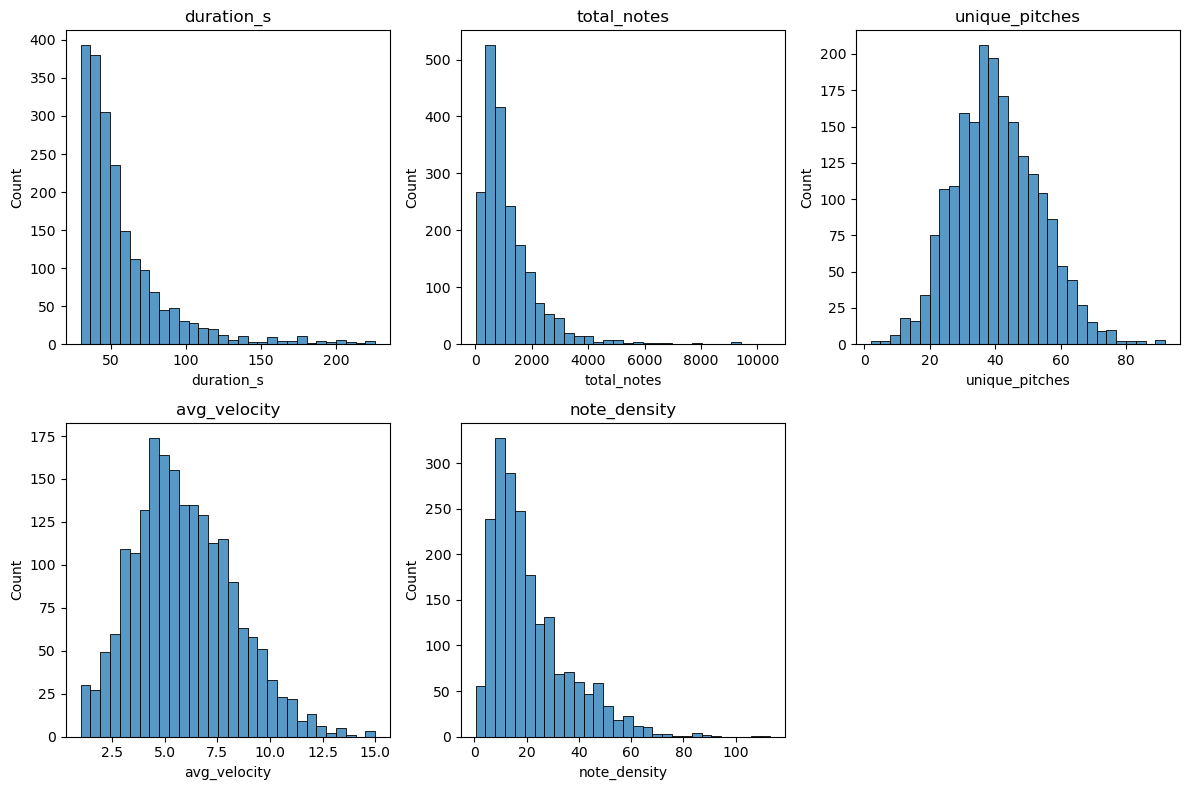

In [15]:
metrics = ['duration_s', 'total_notes', 'unique_pitches', 'avg_velocity', 'note_density']
plt.figure(figsize=(12, 8))
for i, m in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[m].dropna(), bins=30, kde=False)
    plt.title(m)
plt.tight_layout()
plt.show()

## Statistics to note:
- Most pieces are around the 30-60 seconds range.
- The mean for notes is around 1200 notes per piece.
- There is a relatively large distribution for unique pitches across the songs with a mean of 40
- Most velocities are around 3 to 8, with a mean of 6.
- The note density is quite varied between 0-100 but a majority are in the 0-25 range. 

# More Specific Data

In [16]:
ext_records = []
for path in tqdm(cleaned_paths):
    pm = pretty_midi.PrettyMIDI(path)
    # Polyphony: sample time grid for active note counts
    times = np.linspace(0, pm.get_end_time(), num=500)
    active_counts = [sum(1 for inst in pm.instruments for note in inst.notes if note.start <= t < note.end) for t in times]
    max_poly = int(max(active_counts))
    avg_poly = float(np.mean(active_counts))

    # Tempo
    tempo_changes, tempi = pm.get_tempo_changes()
    mean_tempo = float(np.mean(tempi)) if len(tempi)>0 else np.nan
    tempo_range = float(np.max(tempi)-np.min(tempi)) if len(tempi)>1 else 0.0

    # Key and time signature events
    key_sigs = [ks.key_number for ks in pm.key_signature_changes]
    time_sigs = [(ts.numerator, ts.denominator) for ts in pm.time_signature_changes]
    key_mode = key_sigs[0] if key_sigs else None
    time_sig = time_sigs[0] if time_sigs else (None, None)

    # Note durations and IOIs
    note_durs = np.array([note.end-note.start for inst in pm.instruments for note in inst.notes])
    ioi = np.diff([note.start for inst in pm.instruments for note in inst.notes])
    dur_q = np.quantile(note_durs, [0.25, 0.5, 0.75]) if note_durs.size>0 else [np.nan]*3
    ioi_mean = float(np.mean(ioi)) if ioi.size>0 else np.nan
    ioi_var = float(np.var(ioi)) if ioi.size>0 else np.nan

    # Pitch-class histogram
    pitches = [note.pitch % 12 for inst in pm.instruments for note in inst.notes]
    pc_hist = np.bincount(pitches, minlength=12)
    pc_hist_norm = pc_hist / pc_hist.sum() if pc_hist.sum()>0 else pc_hist

    ext_records.append({
        'file': os.path.basename(path),
        'max_polyphony': max_poly,
        'avg_polyphony': avg_poly,
        'mean_tempo_bpm': mean_tempo,
        'tempo_range_bpm': tempo_range,
        'key_signature': key_mode,
        'time_signature': f"{time_sig[0]}/{time_sig[1]}",
        'dur_q1': dur_q[0], 'dur_q2': dur_q[1], 'dur_q3': dur_q[2],
        'ioi_mean': ioi_mean, 'ioi_var': ioi_var,
        **{f'pc_{i}': pc_hist_norm[i] for i in range(12)}
    })

  0%|          | 0/2013 [00:00<?, ?it/s]

,file,max_polyphony,avg_polyphony,mean_tempo_bpm,tempo_range_bpm,key_signature,time_signature,dur_q1,dur_q2,dur_q3,...,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11
count,2013,2013.000000,2013.000000,2013.0,2013.0,0,2013,2013.000000,2013.000000,2013.000000,...,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
unique,2013,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,387_Wizardry_ProvingGroundsofTheMadOverlord_16...,NaN,NaN,NaN,NaN,NaN,4/4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,2013,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.615499,2.566905,120.0,0.0,NaN,NaN,0.071504,0.121002,0.207422,...,0.120876,0.095489,0.103206,0.068060,0.052516,0.087178,0.051729,0.106990,0.068094,0.071102
std,NaN,0.607441,0.564088,0.0,0.0,NaN,NaN,0.144511,0.164656,0.219424,...,0.085997,0.096298,0.087674,0.056704,0.057619,0.061306,0.055128,0.080382,0.062338,0.066379
min,NaN,1.000000,0.384000,120.0,0.0,NaN,NaN,0.000023,0.002041,0.006281,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,3.000000,2.240000,120.0,0.0,NaN,NaN,0.016429,0.049841,0.099955,...,0.059701,0.019355,0.040268,0.025203,0.009272,0.040640,0.009794,0.051724,0.022414,0.024913
50%,NaN,4.000000,2.646000,120.0,0.0,NaN,NaN,0.049070,0.099365,0.150000,...,0.104874,0.066667,0.084026,0.059091,0.035907,0.080402,0.037929,0.091451,0.054429,0.056497
75%,NaN,4.000000,2.952000,120.0,0.0,NaN,NaN,0.095385,0.149342,0.232925,...,0.162775,0.142649,0.143312,0.095238,0.076305,0.120805,0.075479,0.143897,0.097521,0.097826


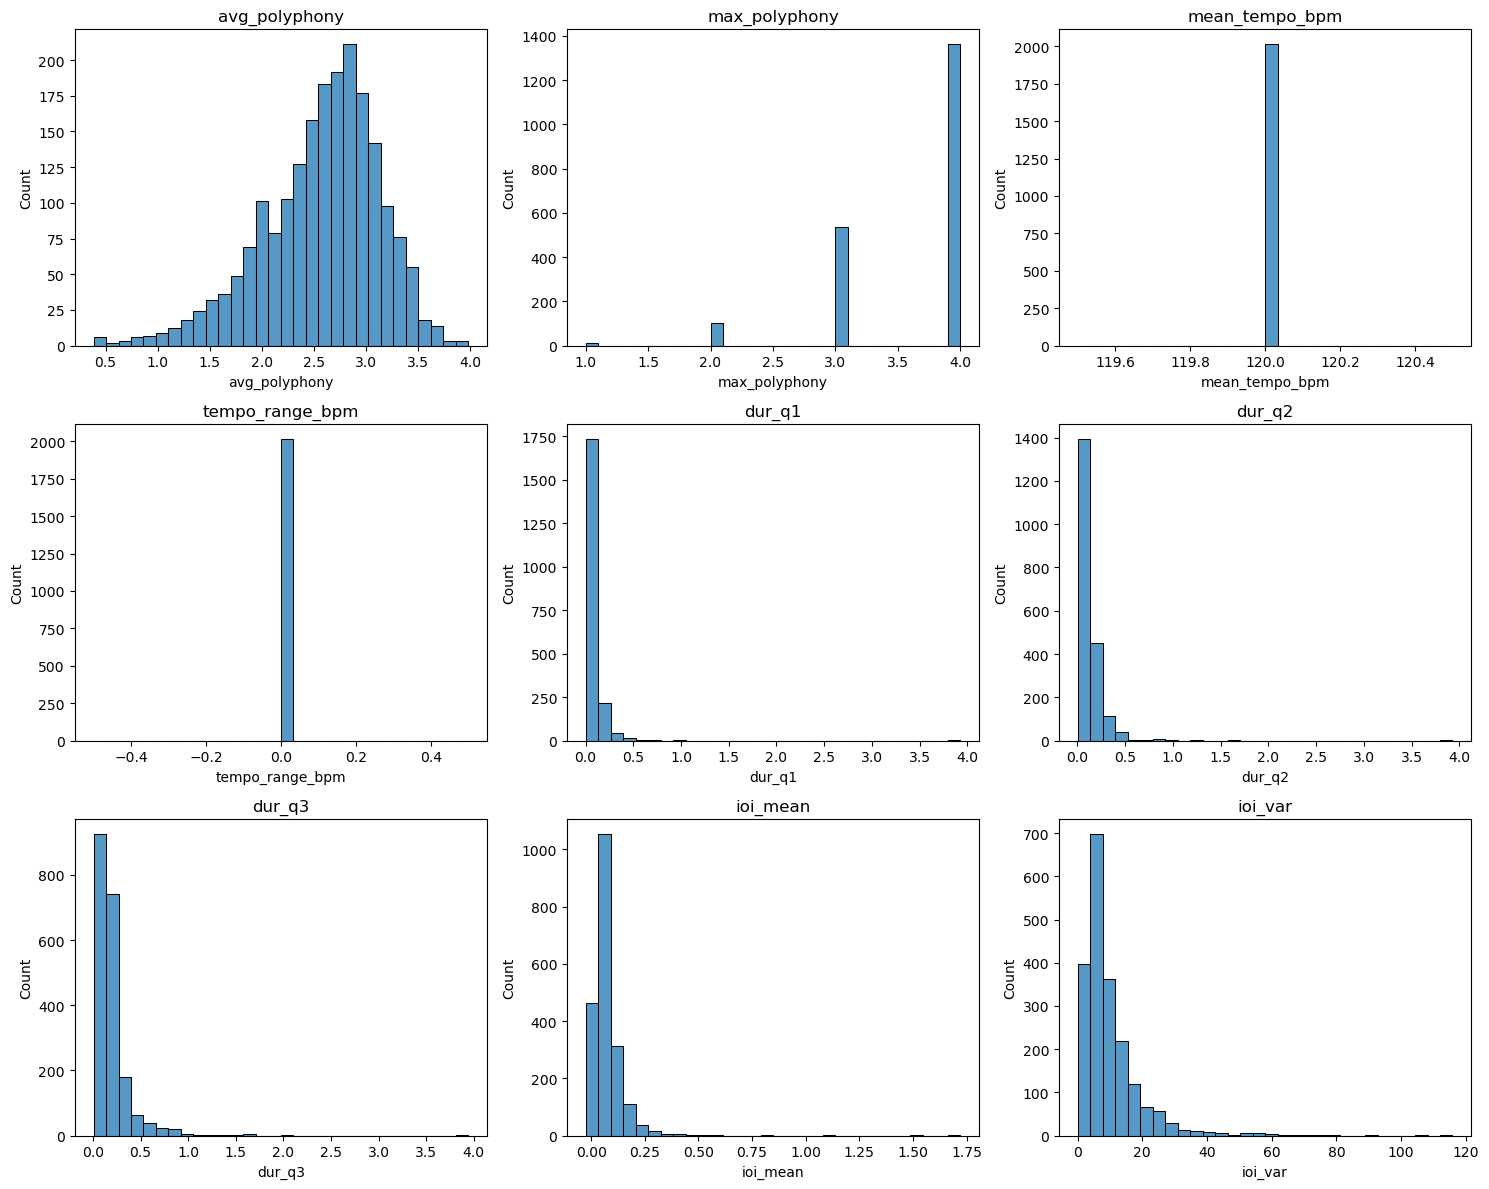

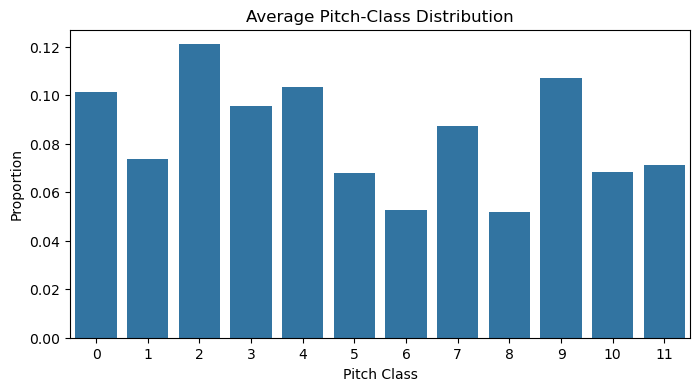

In [17]:
df_ext = pd.DataFrame(ext_records)
display(df_ext.describe(include='all'))

# Histogram plots for extended metrics
ext_metrics = [
    'avg_polyphony', 'max_polyphony',
    'mean_tempo_bpm', 'tempo_range_bpm',
    'dur_q1', 'dur_q2', 'dur_q3',
    'ioi_mean', 'ioi_var'
]
plt.figure(figsize=(15, 12))
for i, m in enumerate(ext_metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_ext[m].dropna(), bins=30)
    plt.title(m)
plt.tight_layout()
plt.show()

# Average pitch-class distribution
pc_cols = [f'pc_{i}' for i in range(12)]
pc_mean = df_ext[pc_cols].mean()
plt.figure(figsize=(8, 4))
sns.barplot(x=list(range(12)), y=pc_mean.values)
plt.title('Average Pitch-Class Distribution')
plt.xlabel('Pitch Class')
plt.ylabel('Proportion')
plt.show()

## Statistics to Note
- Average simultaneous notes (polyphony) peaks around 2.5-3.0; maximum polyphony is frequently 4.
- Songs are consistently at 120 BPM with very little tempo variation.
- Prominent pitch classes include D (most frequent), C, D#, E, G, and A. This suggests keys like D Major or G Major might be common. Assumed 4/4 time.
- Note durations: 25% of notes are shorter than ~0.25s, the median is ~0.5s, and 75% of notes are shorter than ~0.75s.
- The average time between the start of consecutive notes (IOI) is low, peaking around 0.25-0.3 seconds.

# Section 2: Modeling 
1. Context
- ...

2. Discussion
- Baseline Model:
  - 
  - Pros: 
    - 
  - Cons:
    - 
- Markov
  - 
  - Pros
    - 
  - Cons:
    - 
- LSTM 
  - 
    - Pros: 
      - 
    - Cons:
      - 
- Transformer
  - 
    - Pros:
      -
    - Cons:
      -
- Complexity: 
- Efficiency: 
- Implementaiton challenges:
  - Random:
  - Markov: 
  - LSTM: 
  - Transformer

# Code Walk Through

In [20]:
import os
import glob
import random
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pretty_midi
import mido
from symusic import Score
from miditok import REMI, TokenizerConfig
from midiutil import MIDIFile
from tqdm import tqdm
setattr(np, 'int', int)

In [22]:
device = torch.device("mps" if torch.mps.is_available() else"cpu")
print(f"[INFO] Using device: {device}\n")

[INFO] Using device: mps



In [23]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [86]:
# Initial tokenization happening in this block
midi_files = cleaned_paths
len(midi_files)
config = TokenizerConfig(num_velocities=1, use_chords=False)
tokenizer = REMI(config) 
tokenizer.train(vocab_size=1000, files_paths=midi_files)

In [87]:
random.seed(1)
random.shuffle(midi_files)
split = int(0.9 * len(midi_files))
train_files = midi_files[:split]
eval_files = midi_files[split:]

In [88]:
midi = Score(midi_files[0])
tokens = tokenizer(midi)[0].tokens
tokens[:10]

['Bar_None',
 'Position_31',
 'Pitch_73',
 'Velocity_127',
 'Duration_0.2.8',
 'Bar_None',
 'Position_1',
 'Pitch_74',
 'Velocity_127',
 'Duration_0.3.8']

In [89]:
from symusic import Score
import os

# Path to your MIDI file
programs = set()
names = set()
pair = set()
for path in cleaned_paths:
    score = Score(path)
    if score.tracks:
        for track in score.tracks:
            programs.add(track.program)
            names.add(track.name)
            pair.add((track.program, track.name))

print(programs)
print(names)
print(pair)


{80, 81, 38, 121}
{'no', 'p2', 'tr', 'p1'}
{(81, 'p2'), (38, 'tr'), (121, 'no'), (80, 'p1')}


In [90]:
def note_extraction(midi_file):
    score = Score(midi_file)
    tokens = tokenizer(score)[0].tokens
    pitches = [int(t.split('_')[1]) for t in tokens if t.startswith("Pitch_")]
    return pitches

def note_frequency(train_files):
    freq = defaultdict(int)
    for file in tqdm(train_files):
        for pitch in note_extraction(file):
            freq[pitch] += 1
    return dict(freq)

def note_unigram_probability(train_files):
    note_counts = note_frequency(train_files)
    totalNotes = sum(note_counts.values())
    unigramProbabilities = {note : count/ totalNotes for note, count in note_counts.items()}

    
    return unigramProbabilities

def note_bigram_probability(train_files):

    bigramTransitions = defaultdict(list)
    bigramTransitionProbabilities = defaultdict(list)

    bigramCounts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        pitches = note_extraction(file)
        for i, j in zip(pitches, pitches[1:]):
            bigramCounts[i][j] += 1

    T = {}
    P = {}
    for prev, next in bigramCounts.items():
        nextNotes = list(next.keys())
        counts = list(next.values())
        total = sum(counts)
        prob = [c/total for c in counts]
        bigramTransitions[prev] = nextNotes
        bigramTransitionProbabilities[prev] =  prob 

    

    return bigramTransitions, bigramTransitionProbabilities

def sample_next_note(note):
    bigramTransitions, bigramTransitionProbabilities = note_bigram_probability(train_files)
    next = bigramTransitions.get(note)
    probs = bigramTransitionProbabilities.get(note)
    return random.choices(next, weights=probs, k=1)[0]

def note_trigram_probability(train_files):
    trigramTransitions = defaultdict(list)
    trigramTransitionProbabilities = defaultdict(list)
    
    trigram_counts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        pitch = note_extraction(file)
        for i in range(2, len(pitch)):
            note = (pitch[i-2], pitch[i-1])
            trigram_counts[note][pitch[i]] += 1
    for note, next_dict in trigram_counts.items():
        notes  = list(next_dict.keys())
        counts = list(next_dict.values())
        total  = sum(counts)
        probs  = [c/total for c in counts]

        trigramTransitions[note] = notes
        trigramTransitionProbabilities[note] = probs

    return trigramTransitions, trigramTransitionProbabilities

duration2length = {
    '0.1.8': 1, '0.2.8': 2,'0.3.8': 3,'0.4.8': 4,'0.5.8': 5,'0.6.8': 6,'0.7.8': 7,'1.0.8': 8,'1.1.8': 9,'1.2.8': 10,'1.3.8': 11,
    '1.4.8': 12,'1.5.8': 13,'1.6.8': 14,'1.7.8': 15,'2.0.8': 16,'2.1.8': 17,'2.2.8': 18,'2.3.8': 19,'2.4.8': 20,'2.5.8': 21,
    '2.6.8': 22,'2.7.8': 23,'3.0.8': 24,'3.1.8': 25,'3.2.8': 26,'3.3.8': 27,'3.4.8': 28,'3.5.8': 29,'3.6.8': 30,'3.7.8': 31,
    '4.0.4': 32,'4.1.4': 34,'4.2.4': 36,'4.3.4': 38,'5.0.4': 40,'5.1.4': 42,'5.2.4': 44,'5.3.4': 46,'6.0.4': 48,'6.1.4': 50,
    '6.2.4': 52,'6.3.4': 54,'7.0.4': 56,'7.1.4': 58,'7.2.4': 60,'7.3.4': 62,'8.0.4': 64,'8.1.4': 66,'8.2.4': 68,'8.3.4': 70,
    '9.0.4': 72,'9.1.4': 74,'9.2.4': 76,'9.3.4': 78,'10.0.4': 80,'10.1.4': 82,'10.2.4': 84,'10.3.4': 86,'11.0.4': 88,
    '11.1.4': 90,'11.2.4': 92,'11.3.4': 94,'12.0.4': 96
}

def beat_extraction(midi_file):
    score  = Score(midi_file)
    tokens = tokenizer(score)[0].tokens
    output = []

    for i, tok in enumerate(tokens):
        if tok.startswith("Position_"):
            position = int(tok.split("_",1)[1])

            if i+3 < len(tokens) and tokens[i+3].startswith("Duration_"):
                dur_str = tokens[i+3].split("_",1)[1]
                length = duration2length.get(dur_str, 0)

                if length > 0:
                    output.append((position, length))
    return output

def mapped_length_frequency(train_files):
    freq = defaultdict(int)
    for file_path in tqdm(train_files):
        extracted_beats = beat_extraction(file_path) 
        for _, length_val in extracted_beats:
            freq[length_val] += 1
    return dict(freq)

def beat_bigram_probability(train_files):
    bigramBeatTransitions = defaultdict(list)
    bigramBeatTransitionProbabilities = defaultdict(list)
    counts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        beat = beat_extraction(file)
        lengths = [length for _,length in beat]
        for i,j in zip(lengths, lengths[1:]):
            counts[i][j] += 1
    for prev, next in counts.items():
        nextVal = list(next.keys())
        cnts = list(next.values())
        total = sum(cnts)
        probs = [c/total for c in cnts]
        bigramBeatTransitions[prev] = nextVal
        bigramBeatTransitionProbabilities[prev] = probs
    
    return bigramBeatTransitions, bigramBeatTransitionProbabilities

def beat_pos_bigram_probability(train_files):
    bigramBeatPosTransitions = defaultdict(list)
    bigramBeatPosTransitionProbabilities = defaultdict(list)
    
    counts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        for position, length in beat_extraction(file):
            counts[position][length] += 1

    
    for position, length in counts.items():
        vals  = list(length.keys())
        cnts  = list(length.values())
        total = sum(cnts)
        probs = [c/total for c in cnts]
        bigramBeatPosTransitions[position]= vals
        bigramBeatPosTransitionProbabilities[position] = probs

    return bigramBeatPosTransitions, bigramBeatPosTransitionProbabilities

def beat_trigram_probability(train_files):
    trigramBeatTransitions = defaultdict(list)
    trigramBeatTransitionProbabilities = defaultdict(list)

    trigram_counts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        beats = beat_extraction(file)
        for (prev_pos, prev_len), (pos, length) in zip(beats, beats[1:]):
            pair = (prev_len, pos)
            trigram_counts[pair][length] += 1

    trigramBeatTransitions = {}
    trigramBeatTransitionProbabilities = {}
    for pair, next in trigram_counts.items():
        next_lengths = list(next.keys())
        counts = list(next.values())
        total = sum(counts)
        probs = [c/total for c in counts]
        trigramBeatTransitions[pair] = next_lengths
        trigramBeatTransitionProbabilities[pair] = probs
    return trigramBeatTransitions, trigramBeatTransitionProbabilities

# Baseline Random Model

In [91]:
# Create a unigram pitch distribution
pitch_distribution = note_frequency(train_files)
print(f'unigram pitch distribution complete')
print(pitch_distribution)
# Create a unigram beat length distribution
bl_distribution = mapped_length_frequency(train_files)
print(f'unigram beat length distribution complete')
print(bl_distribution)

100%|██████████| 1811/1811 [00:19<00:00, 93.62it/s] 


unigram pitch distribution complete
{73: 11462, 74: 18101, 71: 17539, 69: 24922, 79: 12572, 81: 11176, 82: 5768, 77: 11947, 75: 10871, 70: 13538, 72: 19493, 66: 12477, 65: 17058, 68: 12022, 58: 11668, 98: 1986, 59: 10771, 78: 9001, 61: 8755, 57: 18980, 86: 4640, 85: 4041, 83: 6144, 84: 7107, 80: 6868, 63: 10827, 56: 5668, 54: 5237, 64: 17301, 67: 21679, 76: 16178, 60: 15378, 51: 6306, 62: 17975, 93: 3386, 106: 2379, 92: 2013, 105: 1074, 94: 1462, 55: 9417, 107: 1274, 99: 981, 95: 1456, 87: 2950, 97: 1313, 104: 659, 89: 2619, 101: 510, 90: 1721, 100: 515, 88: 5300, 91: 2516, 103: 453, 96: 1282, 102: 309, 108: 267, 52: 6140, 53: 7706, 50: 7166, 49: 4416, 48: 5614, 47: 4188, 46: 3625, 45: 4949, 44: 1831, 43: 3568, 42: 1501, 41: 2680, 40: 1681, 39: 1940, 38: 2110, 37: 818, 36: 1518, 35: 428, 34: 186, 33: 97}


100%|██████████| 1811/1811 [00:18<00:00, 96.92it/s] 

bigram beat length distribution complete
{2: 87502, 3: 45246, 5: 13809, 26: 1050, 24: 390, 21: 627, 8: 2997, 11: 2444, 18: 441, 19: 1318, 1: 157009, 10: 3423, 68: 36, 9: 3483, 4: 20628, 20: 393, 17: 951, 28: 320, 30: 246, 15: 1361, 6: 12961, 7: 5658, 29: 252, 14: 984, 36: 132, 40: 86, 13: 3657, 12: 913, 25: 213, 32: 221, 50: 27, 52: 195, 38: 218, 16: 1243, 70: 13, 62: 8, 22: 647, 46: 192, 54: 32, 96: 86, 27: 211, 23: 296, 60: 54, 34: 315, 48: 98, 56: 41, 31: 71, 66: 10, 86: 7, 58: 37, 42: 98, 44: 100, 64: 32, 78: 19, 84: 1, 80: 3, 94: 4, 90: 7, 76: 7, 72: 9, 92: 1, 74: 2, 88: 11, 82: 5}


In [96]:
def generate_unigram_8bit_midi(
    out_path: str,
    pitch_distribution: dict,
    bl_distribution: dict,
    num_notes: int = 100,
    program: int = 80,
    channel: int = 0,
    velocity: int = 100,
    tpb: int = 480
):
    # Initialize MIDI file
    mid = mido.MidiFile()
    mid.ticks_per_beat = tpb
    
    # Create a new track
    track = mido.MidiTrack()
    mid.tracks.append(track)

    # Add a program change message
    track.append(mido.Message(
        'program_change',
        program=program,
        time=0,
        channel=channel
    ))
    # Unigram pitches
    pitches = list(pitch_distribution.keys())
    pitch_weights = np.array(list(pitch_distribution.values()), dtype=float)
    pitch_probabilities = pitch_weights / np.sum(pitch_weights)

    # Unigram beat lengths
    bl_values = list(bl_distribution.keys())
    bl_weights = np.array(list(bl_distribution.values()), dtype=float)
    bl_probabilities = bl_weights / np.sum(bl_weights)

    # Generate correct number of notes
    for _ in range(num_notes):
        # Randomly choose a pitch
        chosen_pitch = random.choices(pitches, weights=pitch_probabilities, k=1)[0]

        # Randomly choose a beat length
        chosen_bl = random.choices(bl_values, weights=bl_probabilities, k=1)[0]
        
        # Calculate note duration in ticks
        note_duration_ticks = int((chosen_bl / 8.0) * tpb)

        # Add note_on message
        track.append(mido.Message(
            'note_on',
            note=chosen_pitch,
            velocity=velocity,
            time=0, 
            channel=channel
        ))
        
        # Add note_off message
        track.append(mido.Message(
            'note_off',
            note=chosen_pitch,
            velocity=0,
            time=note_duration_ticks,
            channel=channel
        ))

    # Add End-Of-Track meta message
    track.append(mido.MetaMessage('end_of_track', time=0))
    
    # Save the MIDI file
    mid.save(out_path)
    print(f"Generated MIDI file saved to: {out_path}")

In [97]:
generate_unigram_8bit_midi(
    out_path = 'unigram_8bit_midi.mid',
    pitch_distribution = pitch_distribution,
    bl_distribution = bl_distribution,
    num_notes = 100,
)

Generated MIDI file saved to: unigram_8bit_midi.mid


# Markov Chain Generation

In [104]:
# Calculate ngram probabilities for notes
unigram_pitches_probs = note_unigram_probability(train_files)
bigram_pitches_transitions, bigram_pitches_probs_map = note_bigram_probability(train_files)
trigram_pitches_transitions, trigram_pitches_probs_map = note_trigram_probability(train_files)
print(f'ngram probabilities complete')

# Calculate probabilities for beats (durations)
beat_pos_transitions, beat_pos_probs_map = beat_pos_bigram_probability(train_files)
print(f'beat probabilities complete')
notes_sequence = []
beat_lengths_bl_sequence = []

def generate_markov_8bit_midi(
    out_path: str,
    train_files: list,
    num_events: int = 100,
    program: int = 80,
    channel: int = 0,
    velocity: int = 100,
    tpb: int = 480
):
    # Initialize MIDI file
    mid = mido.MidiFile()
    mid.ticks_per_beat = tpb
    
    # Create a new track
    track = mido.MidiTrack()
    mid.tracks.append(track)

    # Add program change 
    track.append(mido.Message(
        'program_change',
        program=program,
        time=0,
        channel=channel
    ))

    # Generate notes
    for i in tqdm(range(num_events)):
        next_possible_pitches = []
        weights = []
        
        if i == 0:
            next_possible_pitches = list(unigram_pitches_probs.keys())
            weights = list(unigram_pitches_probs.values())
        elif i == 1:
            prev_note = notes_sequence[-1]
            next_possible_pitches = bigram_pitches_transitions.get(prev_note)
            weights = bigram_pitches_probs_map.get(prev_note)
        else:
            prev_prev_note = notes_sequence[-2]
            prev_note = notes_sequence[-1]
            current_trigram_pair = (prev_prev_note, prev_note)
            
            next_possible_pitches = trigram_pitches_transitions.get(current_trigram_pair)
            weights = trigram_pitches_probs_map.get(current_trigram_pair)
        
        # Choose a note
        chosen_note = random.choices(next_possible_pitches, weights=weights, k=1)[0]
        notes_sequence.append(chosen_note)

    # Generate beats
    current_beat_position = 0
    for _ in tqdm(range(num_events)):
        next_possible_bls = beat_pos_transitions.get(current_beat_position)
        beat_weights = beat_pos_probs_map.get(current_beat_position)
        chosen_bl = random.choices(next_possible_bls, weights=beat_weights, k=1)[0]
        
        beat_lengths_bl_sequence.append(chosen_bl)
        current_beat_position = (current_beat_position + chosen_bl) % 32

    # Append notes to MIDI track
    for pitch, bl_value in tqdm(zip(notes_sequence, beat_lengths_bl_sequence)):
        dur_beats = bl_value / 8.0 
        note_duration_ticks = int(dur_beats * tpb)

        track.append(mido.Message(
            'note_on',
            note=pitch,
            velocity=velocity,
            time=0, 
            channel=channel
        ))
        
        track.append(mido.Message(
            'note_off',
            note=pitch,
            velocity=0,
            time=note_duration_ticks,
            channel=channel
        ))

    track.append(mido.MetaMessage('end_of_track', time=0))
    
    mid.save(out_path)

100%|██████████| 1811/1811 [00:18<00:00, 99.31it/s] 


ngram probabilities complete
beat probabilities complete


In [105]:
generate_markov_8bit_midi(
    out_path = 'markov_8bit_midi.mid',
    train_files = train_files,
    num_events = 100,
)

100%|██████████| 100/100 [00:00<00:00, 271651.81it/s]
100it [00:00, 158037.08it/s]


# LSTM Model Generation

In [111]:
# helper function to convert midi to token ids
def midi_to_token_ids(path, tokenizer):
    score  = Score(path)
    tokens = tokenizer(score)[0].tokens
    # look up each token in the tokenizer’s vocab
    return [tokenizer.vocab[t] for t in tokens]

# LSTM model
class REMILanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_size=256, hidden_size=512, n_layers=2, dropout=0.1): # Added dropout, renamed hidden
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Create token embedding layer, map the tokens to the emb_size, 
        # will learn tokens such as pitch, duration, etc.
        self.embedding = nn.Embedding(vocab_size, emb_size)
        # Create LSTM layers
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers, 
                            batch_first=True, dropout=dropout if n_layers > 1 else 0)
        # Decrease overfit
        self.dropout = nn.Dropout(dropout)
        # Project vector back into logits for classification and generation
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden_state=None):
        # Get embedding
        embedded = self.embedding(x)
        # Run LSTM
        lstm_out, hidden_state = self.lstm(embedded, hidden_state)
        # Dropout
        out_dropped = self.dropout(lstm_out)
        # Project output
        logits = self.fc(out_dropped)
        return logits, hidden_state

In [112]:
# --- Dataset Class (Your version) ---
class SeqDataset(Dataset):
    def __init__(self, data, seq_len=128):
        self.token_ids_tensor = torch.tensor(data, dtype=torch.long) # Ensure dtype is long for embedding
        self.corpus_len = len(self.token_ids_tensor)
        self.seq_len = seq_len

    def __len__(self):
        # Number of sequences we can create
        return (self.corpus_len - 1) // self.seq_len 

    def __getitem__(self, i):
        start_idx = i * self.seq_len
        # Input sequence
        x = self.token_ids_tensor[start_idx : start_idx + self.seq_len]
        # Target sequence (shifted by one token)
        y = self.token_ids_tensor[start_idx + 1 : start_idx + 1 + self.seq_len]
        return x, y

In [113]:
def train_epoch(model, dataloader, optimizer, criterion, device, vocab_size_for_loss_reshape):
    model.train()
    total_loss = 0
    for x, y in tqdm(dataloader):
        x = x.to(device) # Target shape: [batch_size, seq_len]
        y = y.to(device) # Target shape: [batch_size, seq_len]
        
        logits, _ = model(x)
        
        # Reshape logits and y
        loss = criterion(logits.view(-1, vocab_size_for_loss_reshape), y.view(-1))
        
        # Carry out step
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # Optional: Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, device, vocab_size_for_loss_reshape):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            logits, _ = model(x) # logits shape: [batch_size, seq_len, vocab_size]
            
            loss = criterion(logits.view(-1, vocab_size_for_loss_reshape), y.view(-1))
            total_loss += loss.item()
            
    return total_loss / len(dataloader)

In [116]:
all_ids_train = []
bar_id   = tokenizer.vocab["Bar_None"]

for f in tqdm(train_files):
    all_ids_train.extend(midi_to_token_ids(f, tokenizer))
    all_ids_train.append(bar_id)
print('Finish preparing train files')

all_ids_eval = []
for f in tqdm(eval_files):
    all_ids_eval.extend(midi_to_token_ids(f, tokenizer))
    all_ids_eval.append(bar_id)
print('Finish preparing eval files')

train_ds = SeqDataset(all_ids_train, seq_len=256)
val_ds   = SeqDataset(all_ids_eval,   seq_len=256)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, drop_last=True)


  0%|          | 0/1811 [00:00<?, ?it/s]

Finish preparing train files


  0%|          | 0/202 [00:00<?, ?it/s]

Finish preparing eval files


In [160]:

model = REMILanguageModel(tokenizer.vocab_size).to(device)
opt   = torch.optim.Adam(model.parameters(), 1e-3)
sch   = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.7)
ce    = nn.CrossEntropyLoss()

NUM_EPOCHS = 10 # Define or get from elsewhere
train_loss_history = []
val_loss_history = []
# Optional: Learning Rate Scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.90) 

print(f"\n--- Training for {NUM_EPOCHS} epochs ---")
# Ensure vocab_size used in train_epoch and evaluate_model matches model's output dimension
# This should be the same vocab_size used when defining the model.
effective_vocab_size = model.fc.out_features # Get vocab_size from the model's last layer

for epoch in range(1, NUM_EPOCHS + 1): # Start epoch from 1 for printing
    avg_train_loss = train_epoch(model, train_loader, opt, ce, device, effective_vocab_size)
    avg_val_loss = evaluate_model(model, val_loader, ce, device, effective_vocab_size) # Assuming val_loader exists
    
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

    if sch: # If you add a scheduler
        sch.step()

    # Perplexity calculation (handle potential math errors for display)
    try:
        train_ppl = math.exp(avg_train_loss)
    except (OverflowError, ValueError): # Catches large values or NaN/inf from loss
        train_ppl = float('inf') # Or float('nan')
        
    try:
        val_ppl = math.exp(avg_val_loss)
    except (OverflowError, ValueError):
        val_ppl = float('inf') # Or float('nan')

    current_lr = opt.param_groups[0]['lr']

    print(f"\tEpoch {epoch}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f} (PPL: {train_ppl:.2f}) | "
          f"Val Loss: {avg_val_loss:.4f} (PPL: {val_ppl:.2f}) | "
          f"LR: {current_lr:.6f}")
    
print("Training finished.")


--- Training for 10 epochs ---
	Epoch 1/10 - Train Loss: 1.8606 (PPL: 6.43) | Val Loss: 1.3932 (PPL: 4.03) | LR: 0.001000
	Epoch 2/10 - Train Loss: 1.2909 (PPL: 3.64) | Val Loss: 1.2485 (PPL: 3.49) | LR: 0.001000
	Epoch 3/10 - Train Loss: 1.1576 (PPL: 3.18) | Val Loss: 1.1739 (PPL: 3.23) | LR: 0.001000
	Epoch 4/10 - Train Loss: 1.0792 (PPL: 2.94) | Val Loss: 1.1447 (PPL: 3.14) | LR: 0.001000
	Epoch 5/10 - Train Loss: 1.0256 (PPL: 2.79) | Val Loss: 1.1264 (PPL: 3.08) | LR: 0.001000
	Epoch 6/10 - Train Loss: 0.9854 (PPL: 2.68) | Val Loss: 1.1132 (PPL: 3.04) | LR: 0.001000
	Epoch 7/10 - Train Loss: 0.9526 (PPL: 2.59) | Val Loss: 1.1069 (PPL: 3.03) | LR: 0.001000
	Epoch 8/10 - Train Loss: 0.9247 (PPL: 2.52) | Val Loss: 1.1070 (PPL: 3.03) | LR: 0.001000
	Epoch 9/10 - Train Loss: 0.9003 (PPL: 2.46) | Val Loss: 1.1080 (PPL: 3.03) | LR: 0.001000
	Epoch 10/10 - Train Loss: 0.8801 (PPL: 2.41) | Val Loss: 1.1087 (PPL: 3.03) | LR: 0.000700
Training finished.


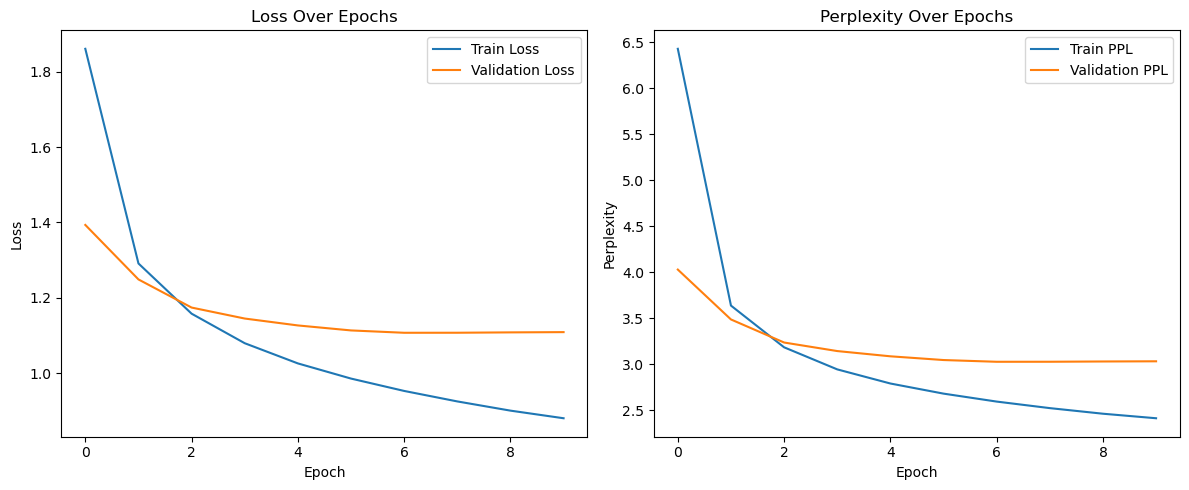

In [161]:
# --- Plotting (can be in a separate cell) ---
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
train_ppl_history = [math.exp(l) if not (math.isnan(l) or math.isinf(l) or abs(l) > 20) else float('nan') for l in train_loss_history]
val_ppl_history = [math.exp(l) if not (math.isnan(l) or math.isinf(l) or abs(l) > 20) else float('nan') for l in val_loss_history]
plt.plot(train_ppl_history, label='Train PPL')
plt.plot(val_ppl_history, label='Validation PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.title('Perplexity Over Epochs')
plt.tight_layout()
plt.show()

In [162]:
def sample_tokens_from_start_lstm(
    model: REMILanguageModel,      # Your trained LSTM model
    tokenizer,                  # Your MidiTok tokenizer (callable for conversions)
    device: torch.device,
    num_tokens_to_generate: int, # Total number of tokens to generate including start
    start_token_str: str = "BOS_None", 
    top_k: int = 10,
    temperature: float = 1.0
):
    model.eval()
    model = model.to(device)
    
    generated_ids = []

    # Get the ID for the start token
    # try:
    #     # Assumes tokenizer("token_string") returns [id]
    #     start_id_list = tokenizer(start_token_str) 
    #     if not (start_id_list and isinstance(start_id_list[0], int)):
    #         raise ValueError(f"Tokenizer did not return a valid ID list for start token '{start_token_str}'")
    #     current_input_id = start_id_list[0]
    # except (KeyError, ValueError, TypeError, Exception) as e:
    #     print(f"Error getting ID for start token '{start_token_str}': {e}.")
    #     # Fallback if the preferred start token isn't found or tokenizer call fails
    #     try:
    #         if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id is not None: # Check if direct attribute exists
    #              current_input_id = tokenizer.bos_token_id
    #              print(f"Using fallback start token: BOS (ID: {current_input_id})")
    #         elif hasattr(tokenizer, 'pad_token_id') and tokenizer.pad_token_id is not None: # Last resort, less ideal
    #              current_input_id = tokenizer.pad_token_id
    #              print(f"Using fallback start token: PAD (ID: {current_input_id})")
    #         else: # Absolute fallback
    #             current_input_id = 0
    #             print(f"Using absolute fallback start token: ID 0")
    #     except Exception as e2:
    #         print(f"Critical error: Could not determine any start token ID: {e2}. Aborting.")
    #         return []
    current_input_id = tokenizer.vocab.get(start_token_str)
            
    generated_ids.append(current_input_id)
    input_tensor = torch.tensor([[current_input_id]], dtype=torch.long, device=device)
    # print(f"Starting generation with token ID: {current_input_id} ('{tokenizer(current_input_id)[0]}')")


    with torch.no_grad():
        # Generate num_tokens_to_generate - 1 new tokens, as the start token is already included
        hidden_state = None
        for _ in tqdm(range(num_tokens_to_generate - 1)): 
            logits, hidden_state = model(input_tensor, hidden_state)
            last_token_logits = logits[0, -1, :] / temperature
            
            top_k_logits, top_k_indices = torch.topk(last_token_logits, top_k)
            top_k_probs = F.softmax(top_k_logits, dim=-1)
            
            chosen_relative_index = torch.multinomial(top_k_probs, 1)
            next_token_id = top_k_indices[chosen_relative_index.item()].item()
            
            generated_ids.append(next_token_id)
            input_tensor = torch.tensor([[next_token_id]], dtype=torch.long, device=device)
            
            # Optional: Stop if EOS token is generated
            # if hasattr(tokenizer, 'eos_token_id') and next_token_id == tokenizer.eos_token_id:
            #     print("EOS token generated. Stopping generation.")
            #     break
                
    return generated_ids

# Modified note and beat extraction functions below for type checking, so that it runs on our LSTM model without issues.
def note_extraction(midi_or_tokens):
    # if someone passed in a bare list of tokens, just use it
    if isinstance(midi_or_tokens, list):
        tokens = midi_or_tokens
    else:
        # otherwise assume it's a file‐path or MidiFile and run Score()
        score  = Score(midi_or_tokens)
        tokens = tokenizer(score)[0].tokens

    pitches = [int(t.split("_",1)[1])
               for t in tokens
               if t.startswith("Pitch_")]
    return pitches

def beat_extraction(midi_or_tokens):
    if isinstance(midi_or_tokens, list):
        tokens = midi_or_tokens
    else:
        score  = Score(midi_or_tokens)
        tokens = tokenizer(score)[0].tokens

    output = []
    for i, tok in enumerate(tokens):
        if tok.startswith("Position_"):
            pos = int(tok.split("_",1)[1])
            # find the Duration_
            if i+3 < len(tokens) and tokens[i+3].startswith("Duration_"):
                dur_str = tokens[i+3].split("_",1)[1]
                bl      = duration2length.get(dur_str, 0)
                if bl > 0:
                    output.append((pos, bl))
    return output

id2token = {v:k for k,v in tokenizer.vocab.items()}

# Convert from tokens back into pitches and beats
def notes_beats_from_ids(ids: list[int]):
    
    # 1) decode into REMI tokens
    events = [id2token[i] for i in ids]

    # 2) fake‐up a minimal Score-like container for your old extractors
    # class FakeScore:
    #     def __init__(self, tokens): self.tokens = tokens
    # fake = FakeScore(events)

    # 3) reuse your existing functions
    pitches = note_extraction(events)
    beats   = beat_extraction(events)
    return pitches, beats

def generate_midi_lstm_from_start(
    model: REMILanguageModel,
    tokenizer,                      # Your trained MidiTok tokenizer instance
    out_path: str,
    device: torch.device,
    notes_beats_from_ids_func,      # Your notes_beats_from_ids function
    # sample_from_model_func,      # Not needed if we use sample_tokens_from_start_lstm
    generation_length: int = 200,   # Total number of tokens in the generated sequence
    start_token_str: str = "BOS_None", # Token to start generation from
    top_k: int = 10,
    temperature: float = 0.8,
    program: int = 80,
    channel: int = 0,
    velocity: int = 100,
    tpb: int = 480
):
    """
    Generates a new MIDI file from scratch using a trained LSTM model,
    starting from a specified token.
    Relies on the tokenizer's callable interface and user-provided helper functions.
    """

    model.eval() # Ensure model is in eval mode

    # --- Generate Token IDs ---
    print(f"Generating {generation_length} tokens starting with '{start_token_str}'...")
    generated_token_ids = sample_tokens_from_start_lstm(
        model=model,
        tokenizer=tokenizer,
        device=device,
        num_tokens_to_generate=generation_length, # Total tokens desired
        start_token_str=start_token_str,
        top_k=top_k,
        temperature=temperature
    )

    if not generated_token_ids or len(generated_token_ids) < 1: # Check if any tokens were generated
        print("Generation failed or produced no tokens.")
        return
        
    print(f"Successfully generated {len(generated_token_ids)} token IDs.")

    # --- Convert Token IDs to Pitches and Beats ---
    # notes_beats_from_ids_func is your function, relying on the global id2token
    print("Converting generated token IDs to notes and beats...")
    try:
        # Your notes_beats_from_ids takes a list of IDs and uses the global id2token
        new_pitches, new_beats_pos_len = notes_beats_from_ids_func(generated_token_ids)
    except Exception as e:
        print(f"Error during notes_beats_from_ids_func: {e}.")
        print("Ensure 'id2token' is correctly populated, and note/beat extraction functions are robust.")
        return
        
    new_beat_lengths = [length for (_pos, length) in new_beats_pos_len]

    if not new_pitches or len(new_pitches) != len(new_beat_lengths):
        print(f"Warning: Mismatch or empty results after musical interpretation. Pitches: {len(new_pitches)}, BeatLs: {len(new_beat_lengths)}. Truncating.")
        min_len = min(len(new_pitches), len(new_beat_lengths))
        new_pitches = new_pitches[:min_len]
        new_beat_lengths = new_beat_lengths[:min_len]
        if not new_pitches:
             print("No musical events to write to MIDI after aligning. Aborting MIDI creation.")
             # Optionally create a minimal MIDI file here if desired
             mid_empty = mido.MidiFile(ticks_per_beat=tpb)
             track_empty = mido.MidiTrack()
             mid_empty.tracks.append(track_empty)
             track_empty.append(mido.Message('program_change', program=program, time=0, channel=channel))
             track_empty.append(mido.MetaMessage('end_of_track', time=0))
             try:
                 mid_empty.save(out_path)
                 print(f"Minimal MIDI (program change only) saved to {out_path}")
             except Exception as e_save: print(f"Error saving minimal MIDI: {e_save}")
             return


    # --- Create New MIDI File ---
    print("Constructing MIDI file...")
    mid = mido.MidiFile(ticks_per_beat=tpb)
    track = mido.MidiTrack()
    mid.tracks.append(track)
    track.append(mido.Message('program_change', program=program, time=0, channel=channel))

    for pitch, bl_value in tqdm(zip(new_pitches, new_beat_lengths)):
        dur_beats = bl_value / 8.0 
        note_duration_ticks = int(dur_beats * tpb)
        track.append(mido.Message('note_on', note=pitch, velocity=velocity, time=0, channel=channel))
        track.append(mido.Message('note_off', note=pitch, velocity=0, time=note_duration_ticks, channel=channel))

    track.append(mido.MetaMessage('end_of_track', time=0))
    
    try:
        mid.save(out_path)
        print(f"Generated LSTM MIDI file saved to: {out_path}")
    except Exception as e:
        print(f"Error saving MIDI file {out_path}: {e}")


In [175]:
generate_midi_lstm_from_start(
    model=model,
    tokenizer=tokenizer,
    out_path='lstm_8bit_midi.mid',
    device=device,
    notes_beats_from_ids_func=notes_beats_from_ids,
    generation_length=2000,
    start_token_str="BOS_None",
    top_k=50,
    temperature=1.4
)

Generating 2000 tokens starting with 'BOS_None'...


  0%|          | 0/1999 [00:00<?, ?it/s]

Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


0it [00:00, ?it/s]

Generated LSTM MIDI file saved to: lstm_8bit_midi.mid


# Transformer Model Generation

In [176]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: [seq_len, batch_size, d_model]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class REMITransformerModel(nn.Module):
    def __init__(self, vocab_size, emb_size=256, nhead=8, nhid=512, nlayers=6, dropout=0.2):
        super().__init__()
        self.model_type = 'Transformer'
        self.emb_size = emb_size
        self.nhead = nhead
        self.nhid = nhid
        self.nlayers = nlayers
        self.dropout = dropout
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        
        decoder_layers = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=nhid, dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers=nlayers)
        
        self.fc_out = nn.Linear(emb_size, vocab_size)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)

    def forward(self, tgt, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None):

        
        tgt_emb = self.embedding(tgt) * math.sqrt(self.emb_size) # Shape: [batch_size, seq_len, emb_size]
        tgt_emb = tgt_emb.transpose(0,1) # Shape: [seq_len, batch_size, emb_size] for pos_encoder
        tgt_emb_pos = self.pos_encoder(tgt_emb) # Shape: [seq_len, batch_size, emb_size]
        tgt_emb_pos = tgt_emb_pos.transpose(0,1) # Shape: [batch_size, seq_len, emb_size] for decoder layer

        if tgt_mask is None:
            sz = tgt.size(1) # seq_len
            tgt_mask = self._generate_square_subsequent_mask(sz).to(tgt.device)


        encoder_layers_for_decoder = nn.TransformerEncoderLayer(d_model=self.emb_size, nhead=self.nhead, dim_feedforward=self.nhid, dropout=self.dropout, batch_first=True)
        self.transformer_as_decoder = nn.TransformerEncoder(encoder_layers_for_decoder, num_layers=self.nlayers)

        
        output = self.transformer_decoder(tgt=tgt_emb_pos, memory=tgt_emb_pos, 
                                          tgt_mask=tgt_mask, 
                                          tgt_key_padding_mask=tgt_key_padding_mask)
                                          # memory_mask and memory_key_padding_mask could also be tgt_mask etc.

        logits = self.fc_out(output) # Shape: [batch_size, seq_len, vocab_size]
        return logits, None # Transformer decoder doesn't return 'hidden_state' in the same way LSTM does
                           # It manages its state internally via attention. For sampling, we feed generated sequence.


In [177]:
from tqdm import tqdm # ensure tqdm is imported

def train_epoch_transformer(model, dataloader, optimizer, criterion, device, vocab_size_for_loss_reshape, pad_idx):
    model.train()
    total_loss = 0
    for x, y in tqdm(dataloader, desc="Training"): # x is input_seq, y is target_seq
        x = x.to(device) # Shape: [batch_size, seq_len]
        y = y.to(device) # Shape: [batch_size, seq_len] (shifted input)

        # Create target key padding mask for 'x' (our target for the decoder)
        # This mask indicates where PAD tokens are in the input 'x'
        # Shape: [batch_size, seq_len]
        tgt_key_padding_mask = (x == pad_idx) # True where x is pad_idx

        # The causal mask is generated inside the model's forward method based on seq_len of x
        
        logits, _ = model(x, tgt_key_padding_mask=tgt_key_padding_mask) # model's forward needs tgt_mask for causality and optionally tgt_key_padding_mask
                                                                    # tgt_mask (causal) is handled internally by model
        
        # Reshape logits and y for loss calculation
        # logits shape: [batch_size, seq_len, vocab_size]
        # y shape: [batch_size, seq_len]
        loss = criterion(logits.view(-1, vocab_size_for_loss_reshape), y.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # Optional
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate_model_transformer(model, dataloader, criterion, device, vocab_size_for_loss_reshape, pad_idx):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Evaluating"):
            x = x.to(device)
            y = y.to(device)

            tgt_key_padding_mask = (x == pad_idx)
            
            logits, _ = model(x, tgt_key_padding_mask=tgt_key_padding_mask)
            
            loss = criterion(logits.view(-1, vocab_size_for_loss_reshape), y.view(-1))
            total_loss += loss.item()
            
    return total_loss / len(dataloader)

In [187]:
# Model Hyperparameters (example)
VOCAB_SIZE = len(tokenizer) # Should be 1000 if BPE was used
EMB_SIZE = 256
NHEAD = 4 # Must be a divisor of EMB_SIZE
NHID = 256 # Dimension of the feedforward network model in nn.TransformerEncoderLayer
NLAYERS = 1 # Number of nn.TransformerEncoderLayer in nn.TransformerEncoder
DROPOUT = 0.1
PAD_IDX = tokenizer.vocab.get("PAD_None", 0)


# Instantiate model, optimizer, criterion
transformer_model = REMITransformerModel(VOCAB_SIZE, EMB_SIZE, NHEAD, NHID, NLAYERS, DROPOUT).to(device)
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4) # Adjust LR
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX) # Important to ignore PAD_IDX in loss

# --- Training Loop ---
NUM_EPOCHS = 10 # Example
train_loss_history_transformer = []
val_loss_history_transformer = []
# effective_vocab_size_transformer = transformer_model.fc_out.out_features # Same as VOCAB_SIZE

print(f"\n--- Training Transformer for {NUM_EPOCHS} epochs ---")
for epoch in range(1, NUM_EPOCHS + 1):
    avg_train_loss = train_epoch_transformer(transformer_model, train_loader, optimizer, criterion, device, VOCAB_SIZE, PAD_IDX)
    avg_val_loss = evaluate_model_transformer(transformer_model, val_loader, criterion, device, VOCAB_SIZE, PAD_IDX)
    
    train_loss_history_transformer.append(avg_train_loss)
    val_loss_history_transformer.append(avg_val_loss)
    
    # Optional: Learning rate scheduler
    # if scheduler: scheduler.step()

    try: train_ppl = math.exp(avg_train_loss)
    except: train_ppl = float('inf')
    try: val_ppl = math.exp(avg_val_loss)
    except: val_ppl = float('inf')
    current_lr = optimizer.param_groups[0]['lr']

    print(f"\tEpoch {epoch}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f} (PPL: {train_ppl:.2f}) | "
          f"Val Loss: {avg_val_loss:.4f} (PPL: {val_ppl:.2f}) | LR: {current_lr:.6f}")

print("Transformer training finished.")


--- Training Transformer for 10 epochs ---


Training:   0%|          | 0/478 [00:00<?, ?it/s]/Users/andrewyang/miniconda3/envs/WAAK/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Evaluating: 100%|██████████| 57/57 [00:01<00:00, 46.92it/s]


	Epoch 1/10 - Train Loss: nan (PPL: nan) | Val Loss: nan (PPL: nan) | LR: 0.000100


Training:  60%|██████    | 287/478 [00:11<00:07, 25.02it/s]


KeyboardInterrupt: 

In [ ]:
def sample_tokens_from_start_transformer(
    model: REMITransformerModel,
    tokenizer, # Your MidiTok tokenizer
    device: torch.device,
    num_tokens_to_generate: int,
    start_token_str: str = "BOS_None", 
    seq_len_for_model: int = 256, # Max sequence length model was trained with (for positional encodings & masking)
    top_k: int = 10,
    temperature: float = 1.0,
    pad_idx: int = 0 # Assuming 0 is PAD_None ID
):
    model.eval()
    model = model.to(device)
    
    # Get the ID for the start token
    current_input_id = tokenizer.vocab.get(start_token_str)
    if current_input_id is None:
        print(f"Warning: start_token_str '{start_token_str}' not in tokenizer.vocab. Using PAD_None (ID {pad_idx}) as start.")
        current_input_id = pad_idx
            
    generated_ids = [current_input_id]

    with torch.no_grad():
        for _ in tqdm(range(num_tokens_to_generate - 1), desc="Generating Tokens"):
            # Prepare input: use the last part of generated_ids, up to seq_len_for_model
            # The input to the transformer should be padded if shorter than seq_len_for_model,
            # or truncated if longer. For generation, we typically feed the current sequence.
            
            input_sequence = generated_ids
            if len(input_sequence) > seq_len_for_model:
                input_sequence = input_sequence[-seq_len_for_model:]
            
            input_tensor = torch.tensor([input_sequence], dtype=torch.long, device=device) # Shape: [1, current_seq_len]

            # No padding mask needed here as we are generating one by one for a single batch item.
            # The causal mask is handled by the model's forward method.
            # tgt_key_padding_mask = (input_tensor == pad_idx) # Not strictly needed for batch_size=1 single sequence generation step
            
            logits, _ = model(input_tensor) # Causal mask is applied inside model based on input_tensor's seq_len
            
            # Get logits for the very last token prediction
            last_token_logits = logits[0, -1, :] / temperature # Shape: [vocab_size]
            
            if top_k > 0:
                top_k_logits, top_k_indices = torch.topk(last_token_logits, top_k)
                top_k_probs = F.softmax(top_k_logits, dim=-1)
                chosen_relative_index = torch.multinomial(top_k_probs, 1)
                next_token_id = top_k_indices[chosen_relative_index.item()].item()
            else: # Sample from full distribution (greedy if temperature is low)
                probs = F.softmax(last_token_logits, dim=-1)
                next_token_id = torch.multinomial(probs, 1).item()
            
            generated_ids.append(next_token_id)
            
            # Optional: Stop if EOS token is generated
            eos_token_id = tokenizer.vocab.get("EOS_None")
            if eos_token_id is not None and next_token_id == eos_token_id:
                print("EOS token generated. Stopping generation.")
                break
                
    return generated_ids

In [ ]:
import mido # Ensure mido is imported
from tqdm import tqdm # Ensure tqdm is imported

def generate_midi_transformer_from_start(
    model: REMITransformerModel,
    tokenizer,
    out_path: str,
    device: torch.device,
    notes_beats_from_ids_func, # Your notes_beats_from_ids function
    generation_length: int = 200,
    start_token_str: str = "BOS_None",
    seq_len_for_model: int = 256, # Max seq len for model context during generation
    top_k: int = 10,
    temperature: float = 0.8,
    program: int = 80, # Default MIDI program
    channel: int = 0,
    velocity: int = 100,
    tpb: int = 480  # Ticks per beat for MIDI
):
    model.eval()
    pad_idx = tokenizer.vocab.get("PAD_None", 0) # Get PAD ID, default to 0

    print(f"Generating {generation_length} tokens starting with '{start_token_str}' using Transformer...")
    generated_token_ids = sample_tokens_from_start_transformer(
        model=model,
        tokenizer=tokenizer,
        device=device,
        num_tokens_to_generate=generation_length,
        start_token_str=start_token_str,
        seq_len_for_model=seq_len_for_model,
        top_k=top_k,
        temperature=temperature,
        pad_idx=pad_idx
    )

    if not generated_token_ids:
        print("Generation failed or produced no tokens.")
        return
    print(f"Successfully generated {len(generated_token_ids)} token IDs.")

    print("Converting generated token IDs to notes and beats...")
    try:
        # notes_beats_from_ids_func relies on global id2token
        new_pitches, new_beats_pos_len = notes_beats_from_ids_func(generated_token_ids)
    except Exception as e:
        print(f"Error during notes_beats_from_ids_func: {e}. Ensure 'id2token' is correct.")
        return
        
    new_beat_lengths = [length for (_pos, length) in new_beats_pos_len]

    if not new_pitches or len(new_pitches) != len(new_beat_lengths):
        print(f"Warning: Mismatch or empty results. Pitches: {len(new_pitches)}, BeatLs: {len(new_beat_lengths)}. Truncating.")
        min_len = min(len(new_pitches), len(new_beat_lengths))
        new_pitches = new_pitches[:min_len]
        new_beat_lengths = new_beat_lengths[:min_len]
        if not new_pitches:
            print("No musical events to write to MIDI. Aborting.")
            # Optionally create minimal MIDI
            mid_empty = mido.MidiFile(ticks_per_beat=tpb)
            track_empty = mido.MidiTrack()
            mid_empty.tracks.append(track_empty)
            track_empty.append(mido.Message('program_change', program=program, time=0, channel=channel))
            track_empty.append(mido.MetaMessage('end_of_track', time=0))
            try: mid_empty.save(out_path); print(f"Minimal MIDI saved to {out_path}")
            except Exception as e_save: print(f"Error saving minimal MIDI: {e_save}")
            return

    print("Constructing MIDI file...")
    mid = mido.MidiFile(ticks_per_beat=tpb)
    track = mido.MidiTrack()
    mid.tracks.append(track)
    track.append(mido.Message('program_change', program=program, time=0, channel=channel))

    for pitch, bl_value in tqdm(zip(new_pitches, new_beat_lengths), total=len(new_pitches), desc="Creating MIDI Events"):
        dur_beats = bl_value / 8.0 
        note_duration_ticks = int(dur_beats * tpb)
        track.append(mido.Message('note_on', note=pitch, velocity=velocity, time=0, channel=channel))
        track.append(mido.Message('note_off', note=pitch, velocity=0, time=note_duration_ticks, channel=channel))

    track.append(mido.MetaMessage('end_of_track', time=0))
    
    try:
        mid.save(out_path)
        print(f"Generated Transformer MIDI file saved to: {out_path}")
    except Exception as e:
        print(f"Error saving MIDI file {out_path}: {e}")


# Evaluation
Our models can be evaluated both quantitatively and qualitatively

In [186]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [264]:
# Generate MIDI files
num_each = 20
length = 200
base_path = "output"
model_names = [
    "baseline",
    "markov", 
    "LSTM", 
    # "transformer"
]

# Generate baseline MIDI files
for i in range(num_each):
    out_path = f"{base_path}/baseline/baseline_{i}.mid"
    generate_unigram_8bit_midi(
        out_path = out_path,
        pitch_distribution = pitch_distribution,
        bl_distribution = bl_distribution,
        num_notes = length,
    )

# Generate Markov MIDI files
for i in range(num_each):
    out_path = f"{base_path}/markov/markov_{i}.mid"
    generate_markov_8bit_midi(
        out_path = out_path,
        train_files = train_files,
        num_events = length,
    )

# Generate LSTM MIDI files
for i in range(num_each):
    out_path = f"{base_path}/LSTM/LSTM_{i}.mid"
    generate_midi_lstm_from_start(
        model=model,
        tokenizer=tokenizer,
        out_path=out_path,
        device=device,
        notes_beats_from_ids_func=notes_beats_from_ids,
        generation_length=length * 10,
        start_token_str="BOS_None",
        top_k=50,
        temperature=1.4
    )

# Generate Transformer MIDI files
# for i in range(num_each):
    # out_path = f"{base_path}/transformer/transformer_{i}.mid"
    # generate_midi_transformer_from_start(
    #     model=model,



Generated MIDI file saved to: output/baseline/baseline_0.mid
Generated MIDI file saved to: output/baseline/baseline_1.mid
Generated MIDI file saved to: output/baseline/baseline_2.mid
Generated MIDI file saved to: output/baseline/baseline_3.mid
Generated MIDI file saved to: output/baseline/baseline_4.mid
Generated MIDI file saved to: output/baseline/baseline_5.mid
Generated MIDI file saved to: output/baseline/baseline_6.mid
Generated MIDI file saved to: output/baseline/baseline_7.mid
Generated MIDI file saved to: output/baseline/baseline_8.mid
Generated MIDI file saved to: output/baseline/baseline_9.mid
Generated MIDI file saved to: output/baseline/baseline_10.mid
Generated MIDI file saved to: output/baseline/baseline_11.mid
Generated MIDI file saved to: output/baseline/baseline_12.mid
Generated MIDI file saved to: output/baseline/baseline_13.mid
Generated MIDI file saved to: output/baseline/baseline_14.mid
Generated MIDI file saved to: output/baseline/baseline_15.mid
Generated MIDI fil

100%|██████████| 200/200 [00:00<00:00, 443841.69it/s]
3300it [00:00, 168521.83it/s]
100%|██████████| 200/200 [00:00<00:00, 481827.00it/s]
3500it [00:00, 172404.42it/s]
100%|██████████| 200/200 [00:00<00:00, 463971.68it/s]
3700it [00:00, 176493.82it/s]
100%|██████████| 200/200 [00:00<00:00, 414866.86it/s]
3900it [00:00, 175667.28it/s]
100%|██████████| 200/200 [00:00<00:00, 499917.04it/s]
4100it [00:00, 179290.48it/s]
100%|██████████| 200/200 [00:00<00:00, 489131.66it/s]
4300it [00:00, 118233.06it/s]
100%|██████████| 200/200 [00:00<00:00, 445491.66it/s]
4500it [00:00, 180165.98it/s]
100%|██████████| 200/200 [00:00<00:00, 467331.92it/s]
4700it [00:00, 177747.18it/s]
100%|██████████| 200/200 [00:00<00:00, 488846.62it/s]
4900it [00:00, 179513.05it/s]
100%|██████████| 200/200 [00:00<00:00, 479623.10it/s]
5100it [00:00, 176475.52it/s]
100%|██████████| 200/200 [00:00<00:00, 497544.96it/s]
5300it [00:00, 34670.64it/s]
100%|██████████| 200/200 [00:00<00:00, 481827.00it/s]
5500it [00:00, 176576.5

Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:08<00:00, 224.36it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


198it [00:00, 134620.23it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_0.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 284.45it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


212it [00:00, 141343.58it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_1.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:06<00:00, 296.09it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


228it [00:00, 139626.41it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_2.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:06<00:00, 292.10it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


216it [00:00, 142001.51it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_3.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:06<00:00, 301.40it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


189it [00:00, 147428.58it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_4.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:06<00:00, 295.35it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


208it [00:00, 144320.14it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_5.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 255.28it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


201it [00:00, 140252.06it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_6.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 285.34it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


237it [00:00, 139574.56it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_7.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 274.81it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


189it [00:00, 146204.99it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_8.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 277.73it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


221it [00:00, 131387.84it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_9.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 282.67it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


169it [00:00, 147306.19it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_10.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 267.95it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


190it [00:00, 140327.13it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_11.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:08<00:00, 234.68it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


215it [00:00, 134112.93it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_12.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 265.98it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


205it [00:00, 137595.19it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_13.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 276.27it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


178it [00:00, 135668.93it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_14.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 280.42it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


195it [00:00, 143363.59it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_15.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 277.43it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


178it [00:00, 134109.24it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_16.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:08<00:00, 245.77it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


189it [00:00, 123805.01it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_17.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 264.25it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


214it [00:00, 133747.74it/s]


Generated LSTM MIDI file saved to: output/LSTM/LSTM_18.mid
Generating 2000 tokens starting with 'BOS_None'...


100%|██████████| 1999/1999 [00:07<00:00, 272.14it/s]


Successfully generated 2000 token IDs.
Converting generated token IDs to notes and beats...
Constructing MIDI file...


190it [00:00, 145928.91it/s]

Generated LSTM MIDI file saved to: output/LSTM/LSTM_19.mid


In [265]:
import mido
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# --- Histogram Bin Configuration (Adjust these based on your data's characteristics) ---
# For MIDI pitches (e.g., A0 to C8)
PITCH_BINS = np.arange(21, 109, 1)  # Edges, so 21 to 108 inclusive

# For pitch classes (0=C, 1=C#, ..., 11=B)
PITCH_CLASS_BINS = np.arange(0, 13, 1) # Edges for 12 bins (0-11)

DURATION_BINS = np.array([0, 0.125, 0.25, 0.375, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, np.inf])
IOI_BINS = np.array([0, 0.125, 0.25, 0.375, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, np.inf])

FEATURE_SPECS = {
    "pitches": PITCH_BINS,
    "pitch_classes": PITCH_CLASS_BINS,
    "durations": DURATION_BINS,
    "iois": IOI_BINS
}

In [266]:
def extract_features_from_midi_file(midi_path, track_idx=0):
    """
    Extracts pitches, durations (in beats), IOIs (in beats), and pitch classes
    from a single MIDI file.
    """
    pitches = []
    durations_in_beats = []
    iois_in_beats = []
    pitch_classes = []

    mid = mido.MidiFile(midi_path)
    tpb = mid.ticks_per_beat if mid.ticks_per_beat > 0 else 480 # Default if not set
    
    track = mid.tracks[track_idx]
    # print(track)
    current_time_abs_ticks = 0
    track_last_note_on_time_abs_ticks = None
    active_notes_in_track = {}  # key: (pitch, channel), value: onset_time_abs_ticks

    for msg in track:
        current_time_abs_ticks += msg.time # msg.time is delta from previous event in track
        if msg.type == 'note_on' and msg.velocity > 0:
            note_key = (msg.note, msg.channel)
            pitches.append(msg.note)
            pitch_classes.append(msg.note % 12)
            active_notes_in_track[note_key] = current_time_abs_ticks
            if track_last_note_on_time_abs_ticks is not None:
                ioi_ticks = current_time_abs_ticks - track_last_note_on_time_abs_ticks
                if tpb > 0: iois_in_beats.append(ioi_ticks / tpb)
            track_last_note_on_time_abs_ticks = current_time_abs_ticks
        elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
            note_key = (msg.note, msg.channel)
            if note_key in active_notes_in_track:
                note_on_time_abs_ticks = active_notes_in_track.pop(note_key)
                duration_ticks = current_time_abs_ticks - note_on_time_abs_ticks
                if tpb > 0: durations_in_beats.append(duration_ticks / tpb)
    
    return {
        "pitches": pitches,
        "durations": durations_in_beats,
        "iois": iois_in_beats,
        "pitch_classes": pitch_classes
    }

def aggregate_features_from_midi_set(list_of_midi_paths, track_idx=0):
    """
    Aggregates features from a list of MIDI file paths.
    """
    aggregated = {
        "pitches": [], "durations": [], "iois": [], "pitch_classes": []
    }
    for path in tqdm(list_of_midi_paths, desc="Extracting features"):
        features = extract_features_from_midi_file(path, track_idx=track_idx)
        # print(features)
        for key in aggregated:
            aggregated[key].extend(features[key])
    # print(aggregated["pitches"])
    return aggregated

In [267]:
eval_features = aggregate_features_from_midi_set(eval_files[:], track_idx=1)
model_features = {}

for model_name in model_names:
    dir = f"{base_path}/{model_name}"
    paths = glob.glob(os.path.join(dir, "*.mid"))
    model_features[model_name] = aggregate_features_from_midi_set(paths)

print('Finished extracting features from evaluation set and generated sets')

Extracting features: 100%|██████████| 20/20 [00:00<00:00, 530.83it/s]

Finished extracting features from evaluation set and generated sets


In [268]:
FEATURES = [feature for feature in FEATURE_SPECS.keys()]

scores = {}
for feature in FEATURES:
    print(feature)
    scores[feature] = {}
    eval_counts, _ = np.histogram(eval_features[feature], bins=FEATURE_SPECS[feature])
    eval_dist = eval_counts / len(eval_features[feature])

    for model_name, features in model_features.items():
        model_counts, _ = np.histogram(features[feature], bins=FEATURE_SPECS[feature])
        model_dist = model_counts / len(features[feature])
        scores[feature][model_name] = cosine_similarity(eval_dist.reshape(1, -1), model_dist.reshape(1, -1))[0][0]

print(scores)


pitches
pitch_classes
durations
iois
{'pitches': {'baseline': 0.9796783125342841, 'markov': 0.9736827527587264, 'LSTM': 0.7890312403042267}, 'pitch_classes': {'baseline': 0.9965864587055088, 'markov': 0.9918525313698174, 'LSTM': 0.8725308688174288}, 'durations': {'baseline': 0.6952002108833042, 'markov': 0.6953515134361231, 'LSTM': 0.6429740103263163}, 'iois': {'baseline': 0.6933533201971264, 'markov': 0.694752732939139, 'LSTM': 0.5851007722691918}}


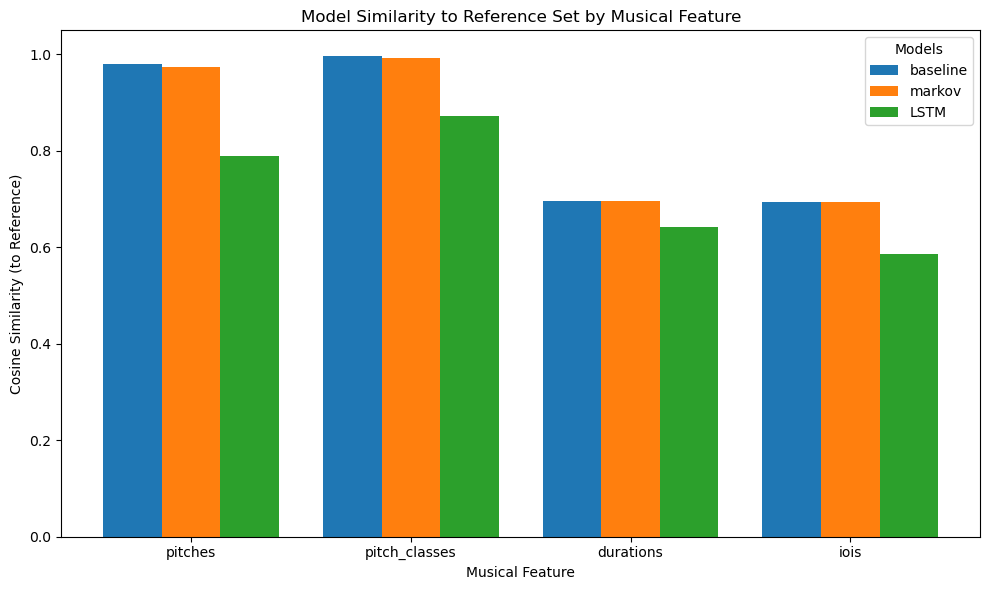

In [270]:
n_features = len(FEATURE_SPECS)
n_models = len(model_names)

bar_width = 0.8 / n_models # Adjust for spacing
index = np.arange(n_features)

fig, ax = plt.subplots(figsize=(max(10, n_features * n_models * 0.5), 6)) # Dynamic width

for i, model_name in enumerate(model_names):
    model_scores = [scores[feature].get(model_name, 0) for feature in FEATURES] # get(feature, 0) handles if a feature might be missing
    
    bar_positions = index + i * bar_width - (bar_width * (n_models -1) / 2) # Center the group
    ax.bar(bar_positions, model_scores, bar_width, label=model_name)

ax.set_xlabel('Musical Feature')
ax.set_ylabel('Cosine Similarity (to Reference)')
ax.set_title('Model Similarity to Reference Set by Musical Feature')
ax.set_xticks(index)
ax.set_xticklabels(scores)
ax.legend(title="Models")
plt.ylim(0, 1.05) # Cosine similarity is between -1 and 1, but for non-negative histograms, it's 0 to 1.
plt.tight_layout()
plt.show()